# DIGIT RECOGNITION

## PREPARING THE ENVIRONMENT

Importing the libraries:

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from random import randint
from sklearn.model_selection import train_test_split

from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,             \
                                    RandomFlip,        \
                                    RandomRotation,    \
                                    RandomZoom,        \
                                    RandomTranslation, \
                                    Conv2D,            \
                                    MaxPooling2D,      \
                                    Dropout,           \
                                    Flatten,           \
                                    Dense

from concurrent.futures import ThreadPoolExecutor

## LOADING DATA

Checking the data present in the `digits` directory:

In [2]:
dirname  = '..\\digits'
datapath = os.listdir(dirname)

N = sum(len(f) for *_, f in os.walk(dirname))
M = len(datapath)

shape  = 32, 32

print('Dataset size   =', N)
print('No. of classes =', M)

Dataset size   = 10160
No. of classes = 10


Getting the images and labels:

- Loading the data
- Transforming to grayscale
- Resizing the image
- Equalizing the histogram

A parallel version of data reading was used, below we demonstrate the iterative version that based the implementation:

```python
shape  = 32, 32

images = np.zeros((N, *shape), dtype='float64')
labels = np.zeros((N, M)     , dtype='uint8'  )

idx = 0
for label in datapath:
    imglabel = int(label)
    filepath = os.path.join(dirname, label)

    for name in os.listdir(filepath):
        image = cv2.imread(os.path.join(filepath, name), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, shape)
        image = cv2.equalizeHist(image)
        image = image / 255.

        images[idx] = image
        labels[idx, imglabel] = 1

        idx += 1
```

In [3]:
def load_folder(dirname, label, shape):
    filepath = os.path.join(dirname, label)
    files    = os.listdir(filepath)

    images = np.zeros((len(files), *shape), dtype='float64')

    idx = 0
    for file in files:
        filename = os.path.join(filepath, file)

        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, shape)
        image = cv2.adaptiveThreshold(image, 255, 1, 1, 11, 2)
        image = image / 255.

        images[idx] = image
        idx += 1

    return images

def load_data(dirname, datapath, N, M, shape):
    images = np.zeros((N, *shape), dtype='float64')
    labels = np.zeros((N, M)     , dtype='uint8'  )

    idx = 0
    with ThreadPoolExecutor() as exec:
        futures = []
        for label in datapath:
            futures.append(exec.submit(load_folder, dirname, label, shape))

        for label, future in enumerate(futures):
            imgs = future.result()

            images[idx:idx + len(imgs)] = imgs
            labels[idx:idx + len(imgs), label] = 1
            idx += len(imgs)

    return images, labels

images, labels = load_data(dirname, datapath, N, M, shape)

Label = [1 0 0 0 0 0 0 0 0 0]


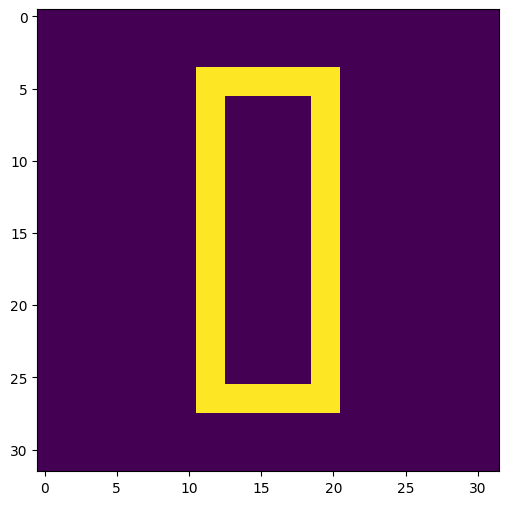

In [4]:
idx   = 0
image = images[idx]
label = labels[idx]

print('Label =', label)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.show()

Spliting the train, validation and test sets:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images , labels , test_size=0.05)
X_train, X_val , y_train, y_val  = train_test_split(X_train, y_train, test_size=0.10)

X_train = np.expand_dims(X_train, axis=-1)
X_val   = np.expand_dims(X_val  , axis=-1)
X_test  = np.expand_dims(X_test , axis=-1)

print('Training   set size =', len(X_train))
print('Validation set size =', len(X_val  ))
print('Test       set size =', len(X_test ))

Training   set size = 8686
Validation set size = 966
Test       set size = 508


## TRAINING A NEURAL NETWORK MODEL

Declaring the neural network architecture used:

In [6]:
model = Sequential()

model.add(Input((32, 32, 1)))
model.add(RandomRotation(0.1))
model.add(RandomZoom(0.2))
model.add(RandomTranslation(height_factor=0.1, width_factor=0.1))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_rotation (RandomRotation)     │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 32, 32, 1)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,167,786 (8.27 MB)

 Trainable params: 2,167,786 (8.27 MB)

 Non-trainable params: 0 (0.00 B)

Training the model:

In [7]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy'     ,
              metrics=['accuracy'])

history = model.fit(X_train, y_train, 32, 35, validation_data=(X_val, y_val))

Epoch 1/35
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.5229 - loss: 1.3825 - val_accuracy: 0.9700 - val_loss: 0.0989
Epoch 2/35
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9059 - loss: 0.2947 - val_accuracy: 0.9814 - val_loss: 0.0553
Epoch 3/35
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9404 - loss: 0.1926 - val_accuracy: 0.9907 - val_loss: 0.0330
Epoch 4/35
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9537 - loss: 0.1523 - val_accuracy: 0.9907 - val_loss: 0.0281
Epoch 5/35
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9584 - loss: 0.1334 - val_accuracy: 0.9907 - val_loss: 0.0264
Epoch 6/35
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.9594 - loss: 0.1137 - val_accuracy: 0.9865 - val_loss: 0.0343
Epoch 7/35
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.9662 - loss: 0.1108 - val_accuracy: 0.9948 - val_loss: 0.0142
Epoch 8/35
272/272 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9668 - loss: 0.1023 - 

Evaluating the model:

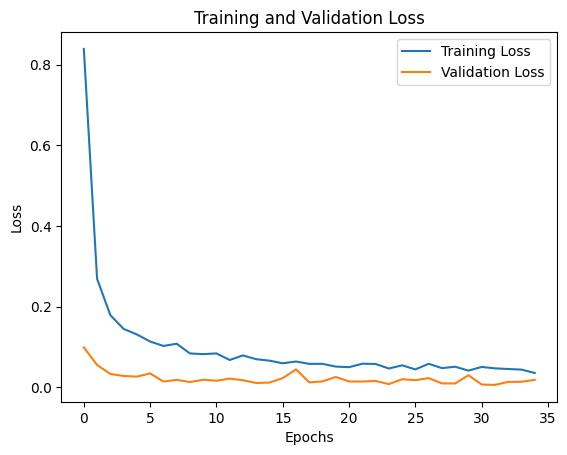

In [8]:
history_dict = history.history

plt.plot(history_dict['loss']    , label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

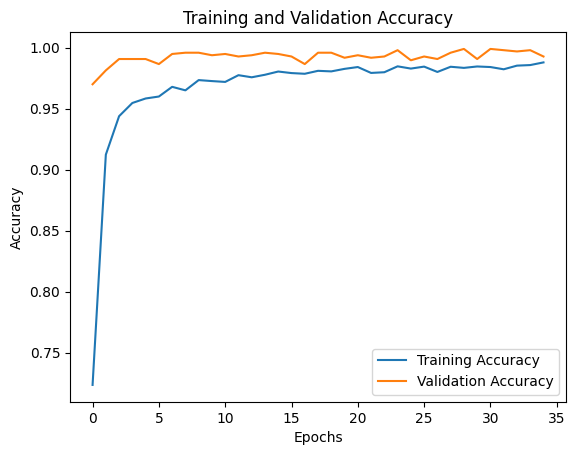

In [9]:
plt.plot(history_dict['accuracy']    , label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [10]:
score, accuracy = model.evaluate(X_test, y_test, verbose=0)

print('Test score    =', score)
print('Test accuracy =', accuracy)

Test score    = 0.015636075288057327
Test accuracy = 0.9960629940032959


Saving the model:

In [11]:
model.save('..\\models\\digits.keras')

## TESTING THE MODEL

Loading the model and testing on different test inputs:

In [12]:
loaded_model = load_model('..\\models\\digits.keras')

N = len(X_test) - 1

preds   = loaded_model.predict(X_test)
classes = np.argmax(preds , axis=1)
labels  = np.argmax(y_test, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


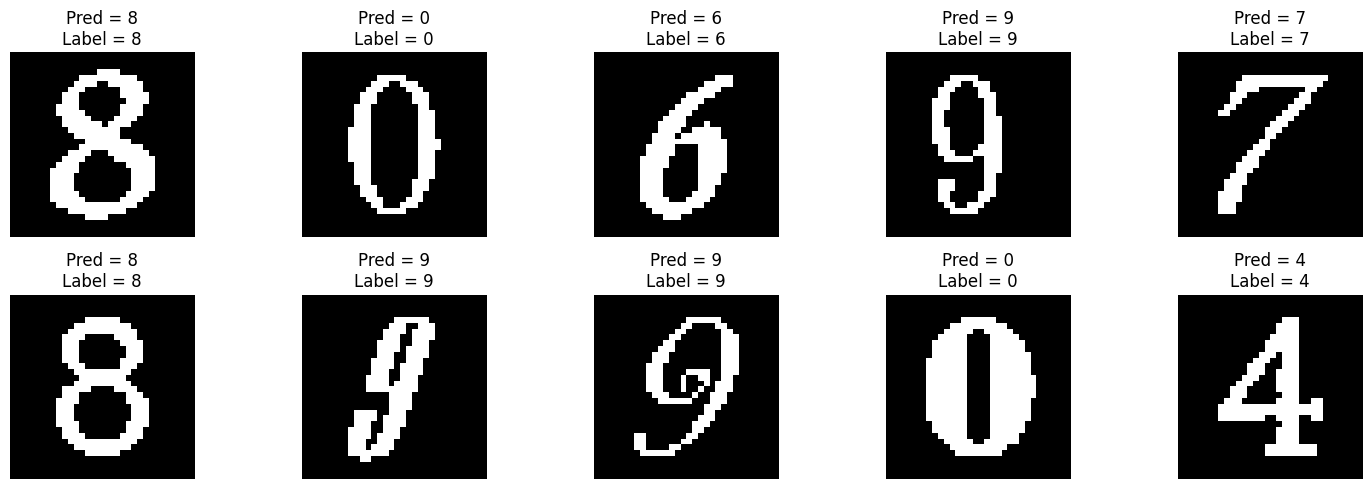

In [13]:
plt.figure(figsize=(15, 5))

idxs = np.random.randint(0, len(X_test), 10)
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')
    plt.title(f'Pred = {classes[idx]}\nLabel = {labels[idx]}')
    plt.axis('off')

plt.tight_layout()
plt.show()